In [2]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import h5py
from math import radians
import pandas as pd
import noise

![Coaxial Cable](coax_structure.png "Coaxial Cable")

In [3]:
class cable_decay:
    # this is a description

    def __init__(self, max_freq, min_freq, channels, a, b, c, rho_in, rho_out, mu_in, mu_out, roughness, eps_dielectric,
                 rho_dielectric, mu_dielectric, tan_d, tcr_in, tcr_out, z_l):
        """
        Calculate the skin depth for a material given the associated properties.
        Parameters
        ----------
        max_freq : float
            Maximum frequency range of S_21 calculation [GHz].
        min_freq : float
            Minimum frequency range of S_21 calculation [GHz].
        channels : int
            Number of channels across specified bandwidth [Dimensionless].
        a : float
            Core radius [meters] (See diagram above).
        b : float
            Dielectric radius [meters] (See diagram above).
        c : float
            Shield radius [meters] (See diagram above).
        rho_in : float
            Core resistivity [ohm*meters].
        rho_out : float
            Shield resistivity [ohm*meters].
        mu_in : float
            Core relative permeability [dimensionless].
        mu_out : float
            Shield relative permeability [dimensionless].
        roughness : float
            Surface roughness [meters].
        eps_dielectric : float
            Dielectric relative permativity [dimensionless].
        rho_dielectric : float
            Dielectric resistivity [ohm*meters].
        mu_dielectric : float
            Dielectric relative permeability [dimensionless].
        tan_d : float
            Dielectric loss tangent [dimensionless].
        tcr_in : float
            Core tempeture Coeficient of Resistance [dimensionless].
        tcr_out : float
            Shield tempeture Coeficient of Resistance [dimensionless].
        z_l : float
            Load impedence [ohms].
        """
        self.max_freq = max_freq * 10 ** 9  # Convert GHz to Hz.
        self.min_freq = min_freq * 10 ** 9  # Convert GHz to Hz.
        self.channels = channels
        self.a = a
        self.b = b
        self.c = c
        self.rho_in = rho_in
        self.rho_out = rho_out
        self.mu_in = mu_in * 4 * np.pi * 10 ** -7  # Convert to core permeability.
        self.mu_out = mu_out * 4 * np.pi * 10 ** -7  # Convert to shield permeability.
        self.roughness = roughness
        self.eps_dielectric = eps_dielectric
        self.rho_dielectric = rho_dielectric
        self.mu_dielectric = mu_dielectric
        self.tan_d = tan_d

        # Tempeture Coeficient of Resistance:
        # https://www.allaboutcircuits.com/textbook/direct-current/chpt-12/temperature-coefficient-resistance/
        self.tcr_in = tcr_in
        self.tcr_out = tcr_out

        self.z_l = z_l

        # Create all frequency & wavelengths for calculations.
        self.frequencies = frequencies = np.linspace(self.min_freq, self.max_freq, channels)  # Hz.
        self.wavelengths = const.speed_of_light / self.frequencies  # meters.

    def skin_depth(self, frequency, mu, rho):
        """
        Calculate the skin depth for a material given the associated properties.
        Parameters
        ----------
        frequency : np.array
            Frequency [meters].
        mu : float
            Pearmeability [meters].
        rho : float
            Resistivity [meters].

        Returns
        -------
        delta : float
            Skin depth
        """
        self.delta = np.sqrt(rho / (np.pi * frequency * mu))
        return self.delta

    def skin_depth_out(self):
        """
        Calculate the skin depth for coax shielding given the associated properties.
        Returns
        -------
        delta : float
            Outer shield skin depth [meters].
        """
        self.delta_out = self.skin_depth(self.frequencies, self.mu_out, self.rho_out)
        return self.delta_out

    def skin_depth_in(self):
        """
        Calculate the skin depth for coax core given the associated properties.
        Returns
        -------
        delta : float
            Inner core skin depth [meters].
        """
        self.delta_in = self.skin_depth(self.frequencies, self.mu_in, self.rho_in)
        return self.delta_in

    def inner_conductor_equivalent_area(self):
        """
        Calculate the coax cable sheilding equivalent area.
        Returns
        -------
        core_area : float
            Coax cable core equivalent area [meters**2]
        """
        self.core_area = 2 * np.pi * self.delta_out * (self.a + self.delta_in * (np.exp(-self.a / self.delta_in) - 1))
        return self.core_area

    def outer_conductor_equivalent_area(self):
        """
        Calculate the coax cable sheilding equivalent area.
        Returns
        -------
        shield_area : float
            Coax cable core equivalent area [meters**2]
        """

        self.shield_area = 2 * np.pi * self.delta_out * (
                self.b + self.delta_out - (self.c + self.delta_out) * np.exp((self.b - self.c) / self.delta_out))
        return self.shield_area

    def surface_roughness_coeff(self):
        """
        Calculate the surface roughness coefficient as a percentage.
        Returns
        -------
        k_sr : float
            Surface roughness coefficent [%].
        """
        self.k_sr_in = 1 + (2 / np.pi) * np.arctan(1.4 * (self.roughness / self.delta_in) ** 2)
        self.k_sr_out = 1 + (2 / np.pi) * np.arctan(1.4 * (self.roughness / self.delta_out) ** 2)
        return self.k_sr_in, self.k_sr_out

    def coax_impedence(self):
        """
        Use coax equation to calculate the impedence, given donut dimensions and properties.
        Returns
        -------
        z_naught : float
            Impedance [ohms].
        """
        self.z_0 = 138 * np.log10(self.b / self.a) / (self.eps_dielectric ** 0.5)
        return self.z_0

    def loss_skin_effect(self):
        """
        Calculate losses associated with the skin effect on the coaxial cable [dB/m].
        Returns
        -------
        loss_delta : np.array(float)
            Loss due to skin effect [dB/m].
        """
        self.loss_delta_in = 8.68588 * (self.rho_in / self.core_area * self.k_sr_in) / (2 * self.z_0)
        self.loss_delta_out = 8.68588 * (self.rho_out / self.shield_area * self.k_sr_out) / (2 * self.z_0)
        self.loss_delta = self.loss_delta_in + self.loss_delta_out
        return self.loss_delta

    def loss_conductivity(self):
        """
        Loss due to conduction in coax dielectric: the only loss mechanism independent of frequency and geometry.
        Returns
        -------
        loss_sigma : np.array(float)
            Loss due to dielectric conductivity [dB/m].
        """
        loss_mhos_per_m = 2 * np.pi / self.rho_dielectric / np.log(self.b / self.a)
        self.loss_sigma = 8.686 * loss_mhos_per_m * self.z_0 / 2
        return self.loss_sigma

    def loss_dielectric_tangent(self):
        """
        Loss tangent is the ratio at any specified frequency between the real and imaginary parts of the impedance of the capacitor. A large loss tangent refers to a high degree of dielectric absorption.
        Returns
        -------
        loss_tangent : np.array(float)
            Loss due to dielectric absorption [dB/m].
        """
        self.loss_tangent = 27.28753 * np.sqrt(self.eps_dielectric) * self.tan_d * self.frequencies / const.c
        return self.loss_tangent

    def loss_thermal(self, temperature):
        """
        The resistance of the cable depends on the operating temperature and thus introdduces another source of loss.
        Parameters
        ----------
        temperature : float
            Temperture of cable operation [Kelvin].

        Returns
        -------
        self.loss_temp : np.array(float)
            Loss due to temperature dependence of resistance [dB/m].
        """
        temp_in_celcius = temperature - 273.15
        self.loss_temp = self.loss_delta_in * (1 + self.tcr_in * (temp_in_celcius - 25)) + self.loss_delta_out * (
                1 + self.tcr_out * (temp_in_celcius - 25))
        return self.loss_temp

    def cable_reflection_coefficient(self):
        """
        Calculate the reflection coefficient: describes percentage of wave reflected by an impedance discontinuity/mismatch in the transmission medium.
        Returns
        -------
        self.reflection_coeff : float
            Reflection coefficiente [dimensionless].
        """
        self.reflection_coeff = (self.z_l - self.z_0) / (self.z_l + self.z_0)
        return self.reflection_coeff

    def atennuate_signal(self, signal, length, temperature, incl_delta=True, incl_sigma=True, incl_tangent=True,
                         incl_thermal=True):
        """
        Apply selected (Skin depth effect, conductivity, tangent & thermal) attenuation to an input signal.
        Parameters
        ----------
        signal : float
            Input signal [dimensionless].
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.

        Returns
        -------
        attenuated_signal : float
            Input signal after various attenuation effects have been applied [dimensionless].
        """
        attenuation = 0

        if incl_delta == True and incl_thermal == False:
            attenuation += self.loss_delta
        if incl_sigma == True:
            attenuation += self.loss_sigma
        if incl_tangent == True:
            attenuation += self.loss_tangent
        if incl_thermal == True:
            attenuation += self.loss_thermal(temperature)

        if incl_delta == False and incl_sigma == False and incl_tangent == False and incl_thermal == False:
            return signal * np.ones(np.shape(self.frequencies))
        elif incl_delta == False and incl_sigma == True and incl_tangent == False and incl_thermal == False:
            return signal * (10 ** (-(attenuation * np.ones(np.shape(self.frequencies)) / 10) * length))
        else:
            return signal * (10 ** (-(attenuation / 10) * length))

    def cable_reflections(self, length, temperature, reflection_no, incl_delta=True, incl_sigma=True, incl_tangent=True,
                          incl_thermal=True):
        """
        Generate superposition of s_21 cable reflections for a given cable length, temperture and reflection order.
        Parameters
        ----------
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        reflection_no : int
            Number of reflections orders to be included [dimensionless].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.

        Returns
        -------
        s_21 : np.array(complex)
            Generated S_21 contribution due to nth order cable reflection.
        """

        v_g = (const.c) / np.sqrt(self.eps_dielectric * self.mu_dielectric)  # m/s
        optical_length = (-1 + 2 * reflection_no) * length
        delay = float(optical_length / v_g)  # seconds
        omega = 2 * np.pi * delay
        signal_amp = self.atennuate_signal(
            np.sin(self.frequencies * omega) * (self.reflection_coeff ** (2*reflection_no)),
            optical_length, temperature, incl_delta=incl_delta, incl_sigma=incl_sigma,
            incl_tangent=incl_tangent, incl_thermal=incl_thermal)
        signal_phase = (2 * np.pi * self.frequencies) * delay
        return [complex(signal_amp[i], signal_phase[i]) for i in range(len(signal_amp))]

    def to_real_imag(self, amp_phase):
        """
        Convert to real and imaginary components, assuming phases are in degrees.
        Parameters
        ----------
        amp_phase : np.array(complex)
            Input amplitudes & phases [dimensionless].

        Returns
        -------
        real_imag : np.array(complex)
            Real & imaginary components in rectangular complex form.
        """
        amp, phase = amp_phase.real, amp_phase.imag

        real_imag = amp * np.exp(1j * phase)
        return complex(np.real(real_imag), np.imag(real_imag))

    def to_amp_phase(self, real_imag):
        """
        Convert to amp and phase components, phases are in degrees.
        Parameters
        ----------
        real_imag : np.array(complex)
            Input real & imaginary components [dimensionless].

        Returns
        -------
        amp_phase ; np.array(complex)
            Amp & phase components in complex form.
        """
        return complex(np.abs(real_imag), np.angle(real_imag))

    def loss_with_length_freq(self, length, temperature, reflection_no, incl_delta=True, incl_sigma=True,
                              incl_tangent=True, incl_thermal=True, incl_reflections=True):
        """
        Apply selected (Skin depth effect, conductivity, tangent & thermal) attenuation to an input signal.
        Parameters
        ----------
        length : float
            Cable length [meters].
        temperature : float
            Temperture of cable operation [Kelvin].
        reflection_no : int
            Number of reflections orders to be included [dimensionless].
        incl_delta : <class 'bool'>
            Include skin effect losses.
        incl_sigma : <class 'bool'>
            Include conductivity effect losses.
        incl_tangent : <class 'bool'>
            Include tangent effect losses.
        incl_thermal : <class 'bool'>
            Include thermal effect losses.
        incl_reflections : <class 'bool'>
            Include cable reflections effect.

        Returns
        -------
        s_21: np.array(complex)
            Generated s21 for the given input parameters.
        """
        signal = self.atennuate_signal(1, length, temperature, incl_delta=incl_delta, incl_sigma=incl_sigma,
                                       incl_tangent=incl_tangent, incl_thermal=incl_thermal)
        self.cable_reflection_coefficient()

        if incl_reflections == True:
            transmittance_amp = signal - signal * self.reflection_coeff
        else:
            transmittance_amp = signal

        transmittance = [self.to_real_imag(complex(transmittance_amp[i], 0)) for i in range(len(transmittance_amp))]
        if incl_reflections is True and reflection_no != 0:
            for order in range(reflection_no):
                reflection = self.cable_reflections(length, temperature, order+1, incl_delta=incl_delta,
                                                    incl_sigma=incl_sigma,
                                                    incl_tangent=incl_tangent, incl_thermal=incl_thermal)
                transmittance = [self.to_real_imag(reflection[i]) + transmittance[i] for i in range(len(reflection))]

        s_21 = np.sqrt(np.abs(transmittance))
        phase = np.imag(self.cable_reflections(length, temperature, 1, incl_delta=incl_delta, incl_sigma=incl_sigma,
                                               incl_tangent=incl_tangent, incl_thermal=incl_thermal))
        return [complex(s_21[i], phase[i]) for i in range(len(s_21))]

In [4]:
# Initalise an RG58 Coaxial Cable across the 1480 channels spaning freq bandwidth [72.0, 108.975]MHz.
ska = cable_decay(max_freq=0.108975, min_freq=0.072, channels=1480, a=0.0004572, b=0.0014732, c=0.0017272,
                  rho_in=1.67*10**-8, rho_out=1.67*10**-8, mu_in=1.0, mu_out=1.0, roughness=0.0, eps_dielectric=2.2, 
                  rho_dielectric=1*10**18, mu_dielectric=1, tan_d=3*10**-4, tcr_in=0.00404, tcr_out=0.00404, z_l=60.0)

#max_freq=0.108975, min_freq=0.072

# Calculate the conductors skin depth & conducting equivalent area. 
ska.skin_depth_in()
ska.skin_depth_out()
ska.inner_conductor_equivalent_area()
ska.outer_conductor_equivalent_area()

# Calculate surface roughness percentage.
ska.surface_roughness_coeff()

# Calculate Coaxial Cable Impedence.
ska.coax_impedence()


ska.loss_skin_effect()
ska.loss_conductivity()
ska.loss_dielectric_tangent()

array([0.00291614, 0.00291715, 0.00291817, ..., 0.00441168, 0.00441269,
       0.0044137 ])

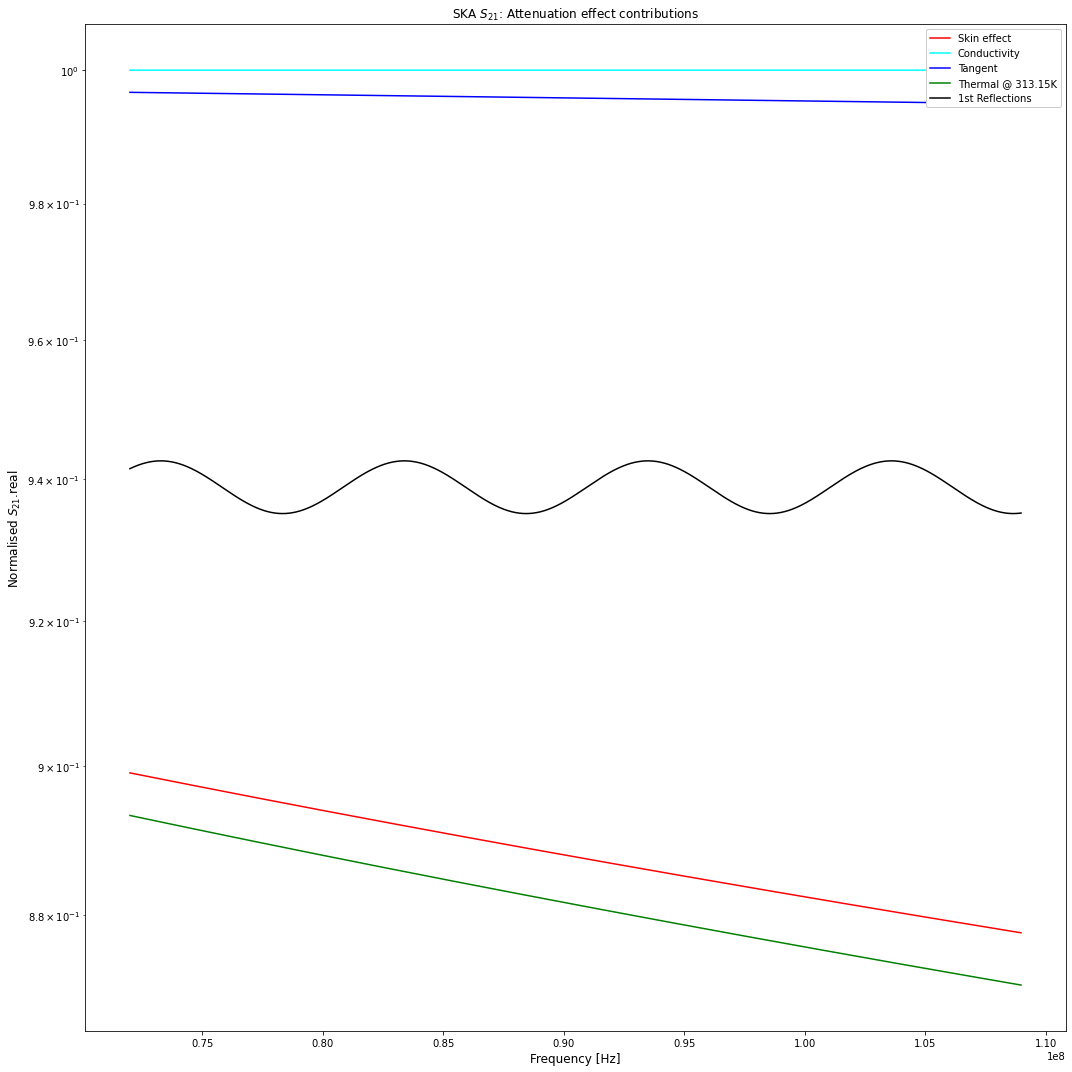

In [5]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15, 15))
data_0 = ska.loss_with_length_freq(10, 293.15, 1, incl_delta=False, incl_sigma=False, incl_tangent=False, incl_thermal=False,
                                   incl_reflections=False)
data_1 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=True, incl_sigma=False, incl_tangent=False, incl_thermal=False,
                                   incl_reflections=False)
data_2 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=False, incl_sigma=True, incl_tangent=False, incl_thermal=False,
                                   incl_reflections=False)
data_3 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=False, incl_sigma=False, incl_tangent=True, incl_thermal=False,
                                   incl_reflections=False)
data_4 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=False, incl_sigma=False, incl_tangent=False, incl_thermal=True,
                                   incl_reflections=False)
data_5 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=False, incl_sigma=False, incl_tangent=False, incl_thermal=False,
                                   incl_reflections=True)

ax.semilogy(ska.frequencies, [data_1[i].real for i in range(len(data_0))], label='Skin effect', color='red')

ax.semilogy(ska.frequencies, [data_2[i].real for i in range(len(data_0))], label='Conductivity', color='cyan')

ax.semilogy(ska.frequencies, [data_3[i].real for i in range(len(data_0))], label='Tangent', color='blue')

ax.semilogy(ska.frequencies, [data_4[i].real for i in range(len(data_0))], label='Thermal @ 313.15K', color='green')

ax.semilogy(ska.frequencies, [data_5[i].real for i in range(len(data_0))], label='1st Reflections', color='black')

ax.set_title('SKA $S_{21}$: Attenuation effect contributions', size='large')

ax.set_ylabel('$S_{21}$.real', size='large')
ax.legend(loc=1, framealpha=1)

ax.set_ylabel('Normalised $S_{21}$.real', size='large')
ax.set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

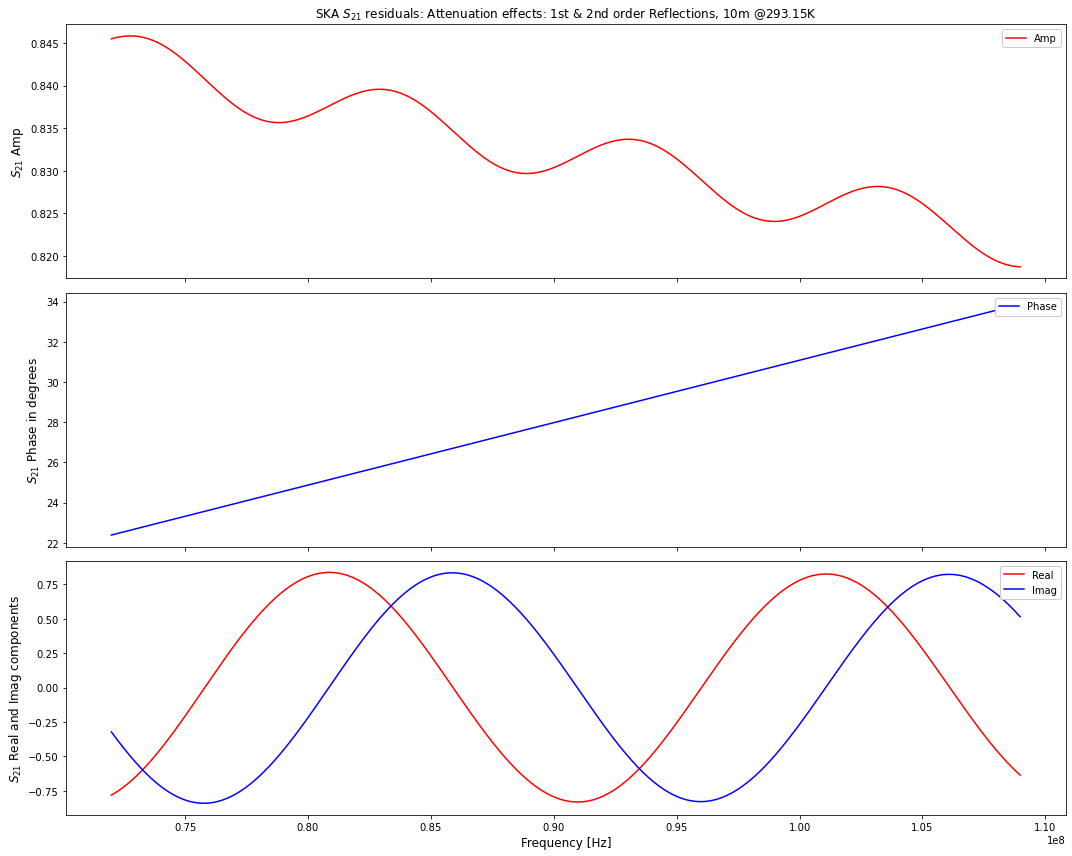

In [6]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15, 12))
data_0 = ska.loss_with_length_freq(10, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)

ax[0].plot(ska.frequencies, [data_0[i].real for i in range(len(data_0))], label='Amp', color='red')
ax[1].plot(ska.frequencies, [data_0[i].imag for i in range(len(data_0))], label='Phase', color='blue')
ax[2].plot(ska.frequencies, [ska.to_real_imag(data_0[i]).real for i in range(len(data_0))], label='Real', color='red')
ax[2].plot(ska.frequencies, [ska.to_real_imag(data_0[i]).imag for i in range(len(data_0))], label='Imag', color='blue')

ax[0].set_title('SKA $S_{21}$ residuals: Attenuation effects: 1st & 2nd order Reflections, 10m @293.15K', size='large')

for a in ax:
    a.legend(loc=1, framealpha=1)
ax[0].set_ylabel('$S_{21}$ Amp', size='large')
ax[1].set_ylabel('$S_{21}$ Phase in degrees', size='large')
ax[2].set_ylabel('$S_{21}$ Real and Imag components', size='large')
ax[2].set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

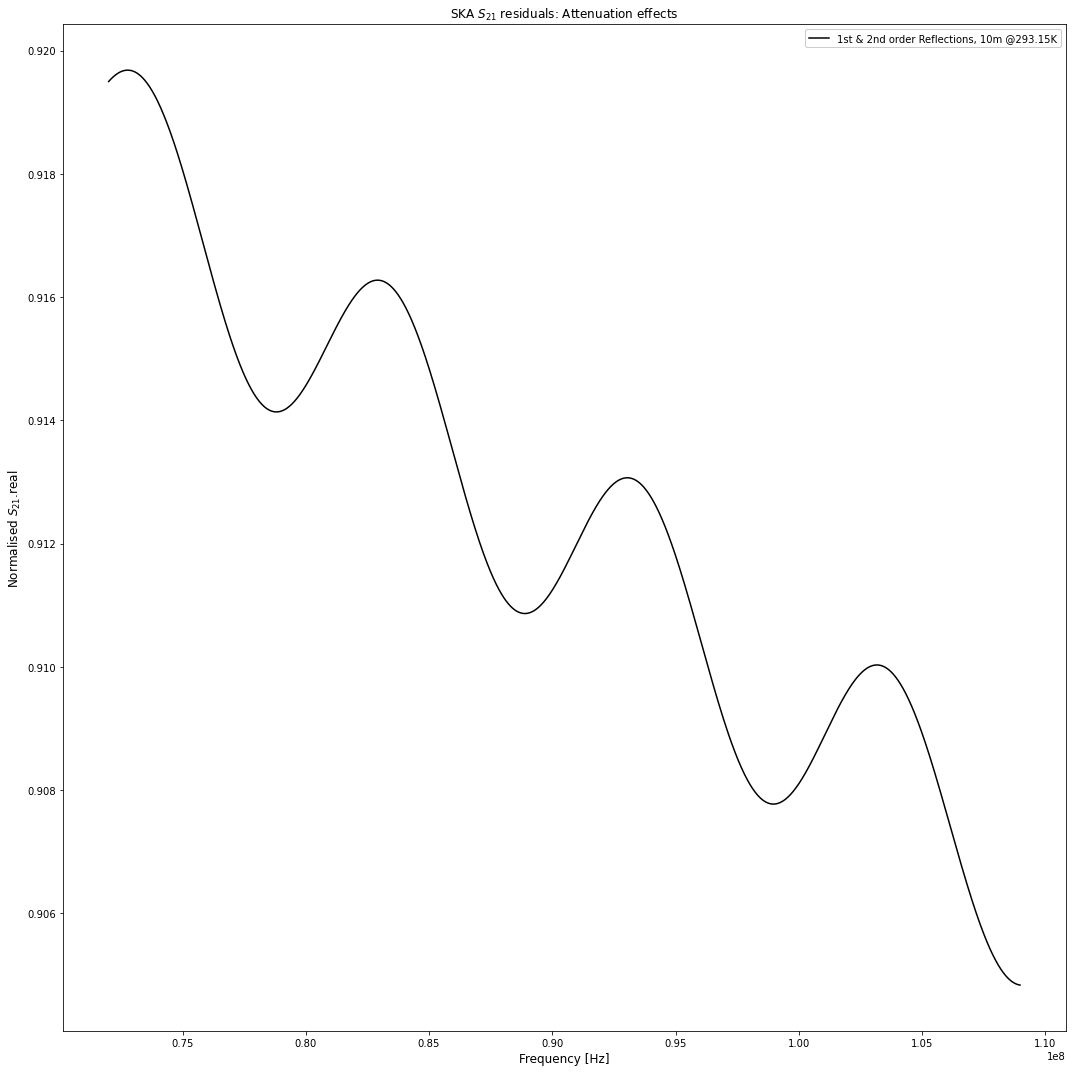

In [7]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15, 15))
data_0 = ska.loss_with_length_freq(10, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)

ax.plot(ska.frequencies, np.sqrt([data_0[i].real for i in range(len(data_0))]), label='1st & 2nd order Reflections, 10m @293.15K', color='black')

ax.set_title('SKA $S_{21}$ residuals: Attenuation effects', size='large')

ax.set_ylabel('Residual $S_{21}$.real', size='large')
ax.legend(loc=1, framealpha=1)

ax.set_ylabel('Normalised $S_{21}$.real', size='large')
ax.set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

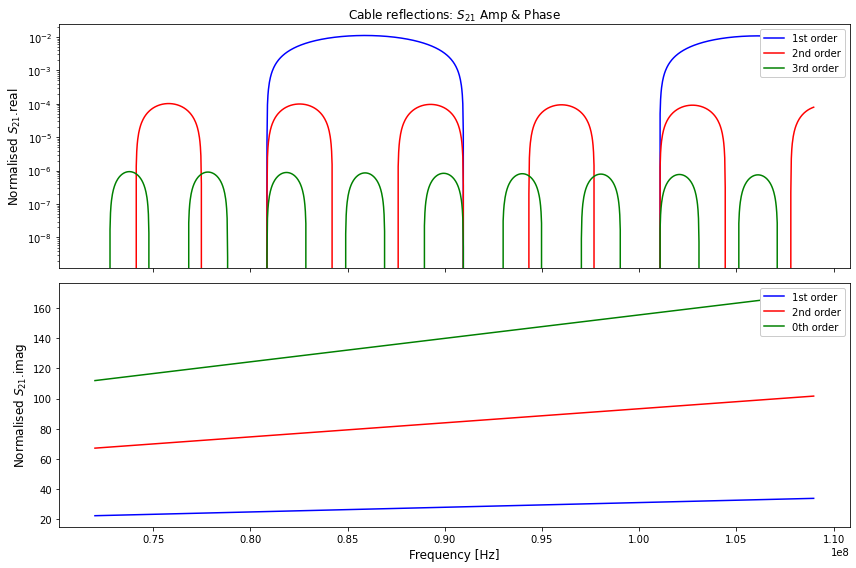

In [8]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
data_0 = ska.loss_with_length_freq(10, 293.15, 1)
data_1 = ska.loss_with_length_freq(10, 293.15, 2)
data_2 = ska.loss_with_length_freq(10, 293.15, 0)

ax[0].semilogy(ska.frequencies, np.real(ska.cable_reflections(10, 293.15, 1)), label='1st order', color='blue')
ax[0].semilogy(ska.frequencies, np.real(ska.cable_reflections(10, 293.15, 2)), label='2nd order', color='red')
ax[0].semilogy(ska.frequencies, np.real(ska.cable_reflections(10, 293.15, 3)), label='3rd order', color='green')

ax[1].plot(ska.frequencies, np.imag(ska.cable_reflections(10, 293.15, 1)), label='1st order', color='blue')
ax[1].plot(ska.frequencies, np.imag(ska.cable_reflections(10, 293.15, 2)), label='2nd order', color='red')
ax[1].plot(ska.frequencies, np.imag(ska.cable_reflections(10, 293.15, 3)), label='0th order', color='green')

ax[0].set_title('Cable reflections: $S_{21}$ Amp & Phase', size='large')
for a in ax:
    a.legend(loc=1, framealpha=1)

ax[0].set_ylabel('Normalised $S_{21}$.real', size='large')
ax[1].set_ylabel('Normalised $S_{21}$.imag', size='large')
ax[1].set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

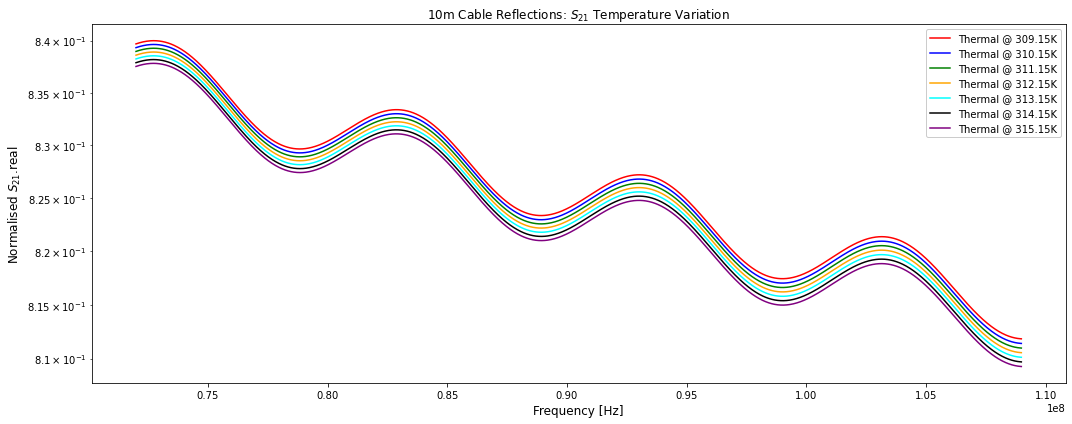

In [9]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15, 6))

data_0 = ska.loss_with_length_freq(10, 309.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_1 = ska.loss_with_length_freq(10, 310.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_2 = ska.loss_with_length_freq(10, 311.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_3 = ska.loss_with_length_freq(10, 312.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_4 = ska.loss_with_length_freq(10, 313.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_5 = ska.loss_with_length_freq(10, 314.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_6 = ska.loss_with_length_freq(10, 315.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)

ax.semilogy(ska.frequencies, [data_0[i].real for i in range(len(data_0))], label='Thermal @ 309.15K', color='red')
ax.semilogy(ska.frequencies, [data_1[i].real for i in range(len(data_0))], label='Thermal @ 310.15K', color='blue')
ax.semilogy(ska.frequencies, [data_2[i].real for i in range(len(data_0))], label='Thermal @ 311.15K', color='green')
ax.semilogy(ska.frequencies, [data_3[i].real for i in range(len(data_0))], label='Thermal @ 312.15K', color='orange')
ax.semilogy(ska.frequencies, [data_4[i].real for i in range(len(data_0))], label='Thermal @ 313.15K', color='cyan')
ax.semilogy(ska.frequencies, [data_5[i].real for i in range(len(data_0))], label='Thermal @ 314.15K', color='black')
ax.semilogy(ska.frequencies, [data_6[i].real for i in range(len(data_0))], label='Thermal @ 315.15K', color='purple')

ax.set_title('10m Cable Reflections: $S_{21}$ Temperature Variation', size='large')

ax.set_ylabel('Residual $S_{21}$.real', size='large')
ax.legend(loc=1, framealpha=1)

ax.set_ylabel('Normalised $S_{21}$.real', size='large')
ax.set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

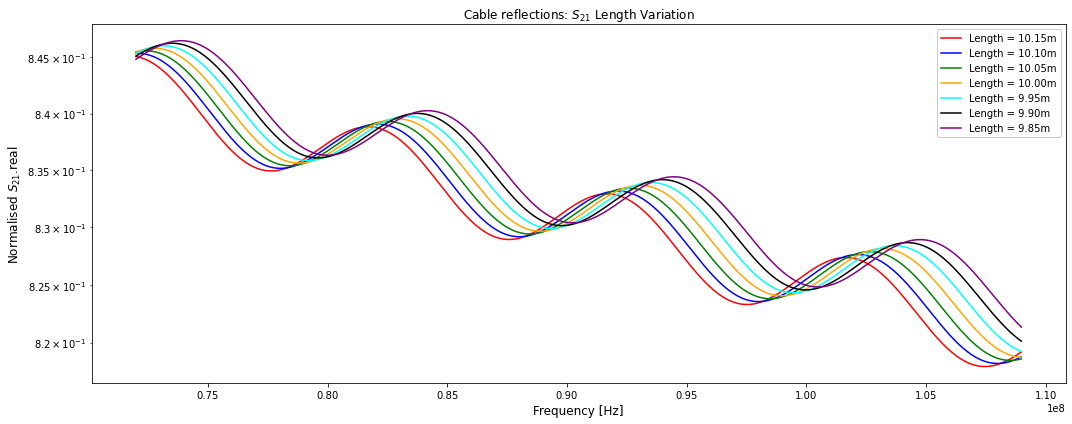

In [10]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15, 6))

data_2 = ska.loss_with_length_freq(10.05, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_1 = ska.loss_with_length_freq(10.1, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_3 = ska.loss_with_length_freq(10, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_4 = ska.loss_with_length_freq(9.95, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_5 = ska.loss_with_length_freq(9.9, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_0 = ska.loss_with_length_freq(10.15, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)
data_6 = ska.loss_with_length_freq(9.85, 293.15, 1, incl_delta=True, incl_sigma=True, incl_tangent=True, incl_thermal=True,
                                   incl_reflections=True)

ax.semilogy(ska.frequencies, [data_0[i].real for i in range(len(data_0))], label='Length = 10.15m', color='red')
ax.semilogy(ska.frequencies, [data_1[i].real for i in range(len(data_0))], label='Length = 10.10m', color='blue')
ax.semilogy(ska.frequencies, [data_2[i].real for i in range(len(data_0))], label='Length = 10.05m', color='green')
ax.semilogy(ska.frequencies, [data_3[i].real for i in range(len(data_0))], label='Length = 10.00m', color='orange')
ax.semilogy(ska.frequencies, [data_4[i].real for i in range(len(data_0))], label='Length = 9.95m', color='cyan')
ax.semilogy(ska.frequencies, [data_5[i].real for i in range(len(data_0))], label='Length = 9.90m', color='black')
ax.semilogy(ska.frequencies, [data_6[i].real for i in range(len(data_0))], label='Length = 9.85m', color='purple')

ax.set_title('Cable reflections: $S_{21}$ Length Variation', size='large')

ax.set_ylabel('Residual $S_{21}$.real', size='large')
ax.legend(loc=1, framealpha=1)

ax.set_ylabel('Normalised $S_{21}$.real', size='large')
ax.set_xlabel('Frequency [Hz]', size='large')
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

In [11]:
def equirectangular_approx(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """    
    r = 6371*10**3 #radius of Earth in Meters
    
    theta_1 = lat1 * np.pi/180
    theta_2 = lat2 * np.pi/180
    delta_theta = (lat2-lat1) * np.pi/180
    delta_lam = (lon2-lon1) * np.pi/180
    
    x = np.sin(delta_lam) * np.cos(theta_2)
    y = np.cos(theta_1) * np.sin(theta_2) - (np.sin(theta_1) * np.cos(theta_2) * np.cos(delta_lam))
    phi = (np.arctan2(x, y) + 3 * np.pi) % (2*np.pi)
    

    a = np.sin(delta_theta/2)**2 + np.cos(theta_1) * np.cos(theta_2) * np.sin(delta_lam/2)**2
    c = 2 * np.arctan(np.sqrt(a)/np.sqrt(1-a))
    rho = r * c

    return [rho, phi] # meters, degrees


def polar_to_cart(rho, phi): # meters, degrees
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return [x, y]


def get_antenna_pos():
    centre = [116.7644482, -26.82472208] # lat , lon
    station_dist_from_centre = []
    station_pos = pd.read_csv('./antenna_pos/layout_wgs84.txt', header=None, names=["latitude", "longitude"])
    station_pos['lat_rel'] = (station_pos['latitude']- centre[0] )
    station_pos['lon_rel'] = (station_pos['longitude'] - centre[1])
    station_pos['rho'], station_pos['phi'] = equirectangular_approx(station_pos['lat_rel'], station_pos['lon_rel'], 0.0, 0.0)
    station_pos['x'], station_pos['y'] = polar_to_cart(station_pos['rho'], station_pos['phi'])

    antenna_info = pd.DataFrame(columns=['station', 'x', 'y'])
    for i, x, y in zip(range(512), station_pos['x'], station_pos['y']):
        df = pd.read_csv('./antenna_pos/station' + str(i).rjust(3, '0') + '/layout.txt', header=None, names=["delta_x", "delta_y"])
        df['delta_x'], df['delta_y'] = df['delta_x']+x, df['delta_y']+y
        df['station'] = i
        df = df[['station', "delta_x", "delta_y"]]
        antenna_info = antenna_info.append(pd.DataFrame(df.to_dict('split')['data'], columns=['station', "x", "y"]), ignore_index=True)
    return antenna_info


def to_hdf5(gains, frequencies, station, folder):    
    # Write HDF5 file with recognised dataset names.
    with h5py.File("./" + folder + "/gain_model_station_" + str(station) + ".h5", "w") as hdf_file:
        hdf_file.create_dataset("freq (Hz)", data=frequencies)
        hdf_file.create_dataset("gain_xpol", data=gains)
        

In [12]:
antenna_info=get_antenna_pos()

In [13]:
shape = (1000,1000)
scale = np.random.uniform(800.0, 1200.0)
octaves = np.random.randint(10,20)
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.snoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity,  
                                    base=0)

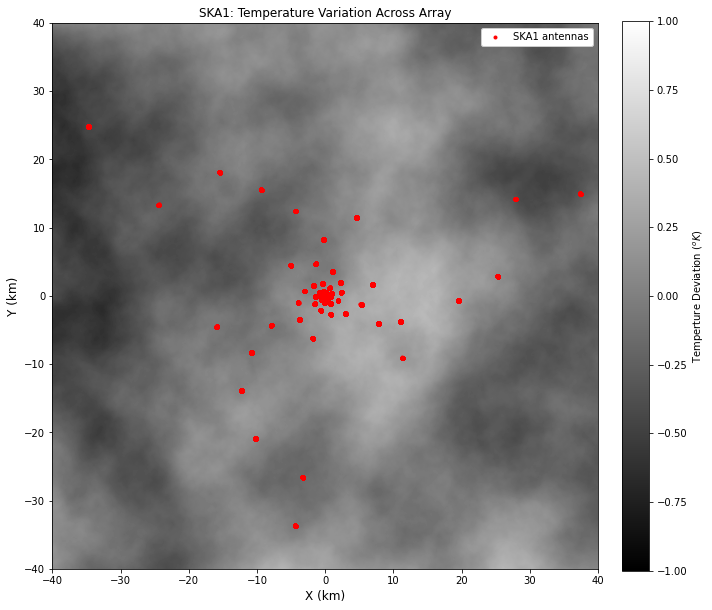

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

t_map = ax.imshow(world, cmap='gray', extent=[-world.shape[1]/(0.025*shape[0]), world.shape[1]/(0.025*shape[0]), -world.shape[0]/(0.025*shape[1]), world.shape[0]/(0.025*shape[1])], vmin=-1, vmax=1)
ax.plot(antenna_info['x']/1000, antenna_info['y']/1000, "o", markersize=3, color='r', label='SKA1 antennas')

ax.set_title('SKA1: Temperature Variation Across Array', size='large')
ax.set_ylabel('Y (km)', size='large')
ax.set_xlabel('X (km)', size='large')

bar = plt.colorbar(t_map, label='Temperture Deviation ($^{o}K$)', fraction=0.046, pad=0.04)

ax.legend(loc=1, framealpha=1)
plt.subplots_adjust(hspace=0.01)
fig.tight_layout()
plt.show()

In [ ]:
folder = "antenna_gains_ref3"

atten_skin_effect     = False
atten_conductivity    = False
atten_tangent         = False
atten_thermal         = False
base_temperature      = 298.15  # Temperature of simulation (K)
cable_reflections     = True
reflection_order      = 3       # integer values 1,2,3,...,n
intended_length       = 10      # meters
length_variation      = 0.00    # percentage of length

antenna_info['cable_length'] = np.random.normal(intended_length, intended_length * length_variation, len(antenna_info.index))
antenna_info['delta_t'] = [base_temperature + world[round((x/40000)*shape[0]/2+shape[0]/2)][round((y/40000)*shape[1]/2+shape[1]/2)] for x, y in zip(antenna_info['x'], antenna_info['y'])]

antenna_info['s_21_amp_phase'] = [ska.loss_with_length_freq(l, dt, reflection_order, incl_delta=atten_skin_effect,
                                                            incl_sigma=atten_conductivity,
                                                            incl_tangent=atten_tangent,
                                                            incl_thermal=atten_thermal,
                                                            incl_reflections=cable_reflections) for l, dt in zip(antenna_info['cable_length'], antenna_info['delta_t'])]
antenna_info['s_21_real_imag'] = [[ska.to_real_imag(data[i]) for i in range(len(data_0))] for data in antenna_info['s_21_amp_phase']]

antenna_info

In [ ]:
for n in range(512): 
    rows = antenna_info[pd.DataFrame(antenna_info.station.tolist()).isin([n]).values]['s_21_real_imag'].values
    data = []
    [data.append(np.array(rows[i])) for i in range(len(rows))]
    to_hdf5(list(np.array([np.transpose(data)])), ska.frequencies, str(n), folder)